In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from scipy import signal
import numpy as np
import matplotlib.pyplot as plt

import itertools
from tqdm import tqdm

In [2]:
def generate_patterns(n):
    input_patterns = []
    for pattern in itertools.product([0,1],repeat=n):
        input_patterns.append(pattern)
    return torch.tensor(input_patterns).type(torch.float32)

class dentate_network(nn.Module):
    def __init__(self, lr):
        self.lr = lr
        self.input_size = 7
        self.output_size = 128
        self.ffi_size = 7
        
        super().__init__()

        self.out_in  = nn.Linear(self.input_size, self.output_size)
        self.ffi_in  = nn.Linear(self.input_size, self.ffi_size)
        self.out_ffi = nn.Linear(self.ffi_size, self.output_size)
        
        self.activation = nn.Sigmoid()
        
        # Initialize weights to positive values
        self.out_in.weight.data = self.out_in.weight.data.log_normal_(0, 1)
        self.ffi_in.weight.data = self.ffi_in.weight.data.uniform_(0, 1)
        self.out_ffi.weight.data = self.out_ffi.weight.data.uniform_(-1, 0)


        self.lossCriterion = nn.MSELoss()
        self.optimizer = torch.optim.SGD(self.parameters(), lr=lr)
        
        
    def forward(self, input_pattern):
        out1 = self.out_in(input_pattern)
        
        out2 = self.ffi_in(input_pattern)
        out2 = self.out_ffi(out2)
        
        output = out1 + out2
        output = self.activation(output)
        
        return output
    
    
    def train(self,epochs,all_patterns):
        losses = []
        for i in tqdm(range(epochs)): 
            self.optimizer.zero_grad()
            
            self.out_in.weight.data = self.out_in.weight.data.clamp(0,100)
            self.ffi_in.weight.data = self.ffi_in.weight.data.clamp(0,100)
            self.out_ffi.weight.data = self.out_ffi.weight.data.clamp(-100,0)

            output = self.forward(all_patterns)
            target = torch.eye(128)

            loss = self.lossCriterion(output,target)
            losses.append(loss.detach())
            loss.backward()
                
#             for i,input_pattern in enumerate(all_patterns):
#                 self.out_in.weight.data = self.out_in.weight.data.clamp(0,100)
#                 self.ffi_in.weight.data = self.ffi_in.weight.data.clamp(0,100)
#                 self.out_ffi.weight.data = self.out_ffi.weight.data.clamp(-100,0)

#                 output = self.forward(input_pattern)
#                 target = torch.eye(128)[pattern_index]

#                 loss = self.lossCriterion(output,target)
#                 losses.append(loss.detach())
#                 loss.backward()
                
            self.optimizer.step()

        return losses

In [3]:
simple_net = dentate_network(lr=1)
all_patterns = generate_patterns(7)

w_init = {'out_in': simple_net.out_in.weight.detach().numpy().flatten(),
          'ffi_in': simple_net.ffi_in.weight.detach().numpy().flatten(),
          'out_ffi': simple_net.out_ffi.weight.detach().numpy().flatten()}

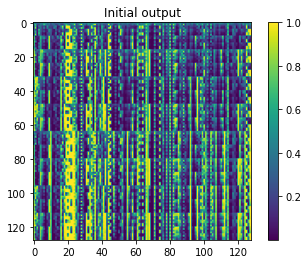

In [4]:
output = []
for pattern in all_patterns:
    output.append(list(simple_net.forward(pattern).detach()))
output = np.array(output)

plt.imshow(output)
plt.colorbar()
plt.title('Initial output')
plt.show()

In [5]:
epochs = 10**5
losses = simple_net.train(epochs, all_patterns)

100%|██████████| 100000/100000 [00:40<00:00, 2471.56it/s]


In [6]:
w_final = {'out_in': simple_net.out_in.weight.detach().numpy().flatten(),
          'ffi_in': simple_net.ffi_in.weight.detach().numpy().flatten(),
          'out_ffi': simple_net.out_ffi.weight.detach().numpy().flatten()}

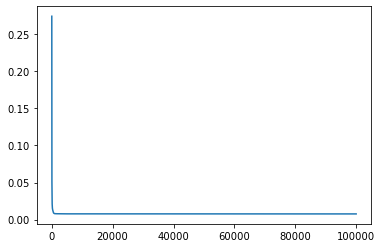

In [7]:
plt.plot(losses)

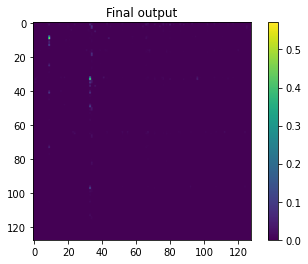

In [8]:
output = []
for pattern in all_patterns:
    output.append(list(simple_net.forward(pattern).detach()))
output = np.array(output)

plt.imshow(output)
plt.colorbar()
plt.title('Final output')
plt.show()

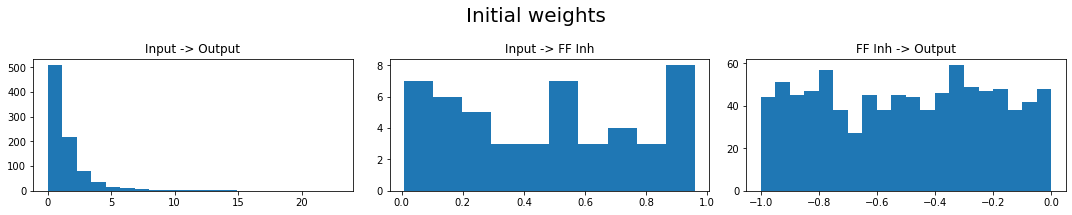

In [9]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,3))

ax1.hist(w_init['out_in'],20)
ax1.set_title('Input -> Output')

ax2.hist(w_init['ffi_in'],10)
ax2.set_title('Input -> FF Inh')

ax3.hist(w_init['out_ffi'],20)
ax3.set_title('FF Inh -> Output')

plt.suptitle('Initial weights',fontsize=20)

fig.tight_layout()
plt.show()

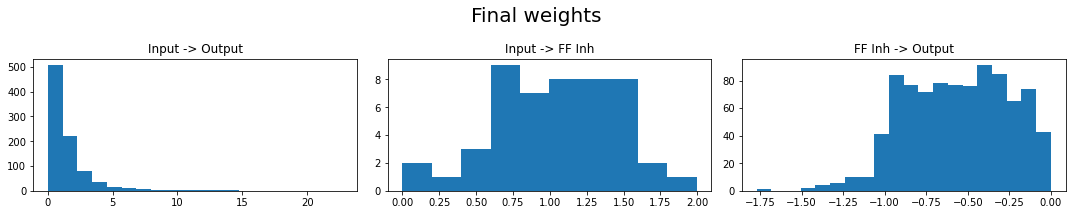

In [10]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,3))

ax1.hist(w_final['out_in'],20)
ax1.set_title('Input -> Output')

ax2.hist(w_final['ffi_in'],10)
ax2.set_title('Input -> FF Inh')

ax3.hist(w_final['out_ffi'],20)
ax3.set_title('FF Inh -> Output')

plt.suptitle('Final weights',fontsize=20)

fig.tight_layout()
plt.show()
